# Importing Libraries

In [ ]:
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import os
import sys
import matplotlib.pyplot as plt

# setting hyperparameters
batch_size = 64
n_channels = 3
learning_rate = 0.0001
lambda_gp = 10
noise_dim = 100
dataset = "cifar10"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

generator_iters = 20000
critic_iter = 5

# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
img_path = '/content/gdrive/MyDrive/CWGAN/tfcifar/'

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(n_channels)], [0.5 for _ in range(n_channels)]
        ),
    ]
)

# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for i, (x, labels) in enumerate(iterable):
            yield x, labels


In [ ]:
#load cifar dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        "drive/My Drive/training/cifar10",
        train=True,
        download=True,
        transform=transforms,
    ),
    shuffle=True,
    batch_size=batch_size,
    drop_last=True,
)
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

train_iterator = iter(cycle(train_loader))
data = cycle(train_loader)


100%|██████████| 170498071/170498071 [00:13<00:00, 12756091.78it/s]


Extracting drive/My Drive/training/cifar10/cifar-10-python.tar.gz to drive/My Drive/training/cifar10


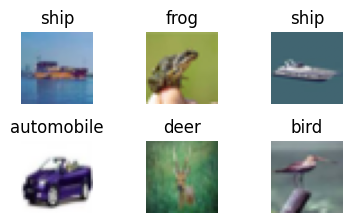

In [ ]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = 10
images, labels = data.__next__()  # Access first sample

fig, axs = plt.subplots(2, 3, figsize=(4, 2.33))

for i, ax in enumerate(axs.flat):
  image = images[i].mul(0.5).add(0.5).permute(1, 2, 0)  # Permute for channels first
  ax.imshow(image.numpy())
  if class_names is not None:
    ax.set_title(class_names[labels[i]])

  ax.axis("off")

plt.tight_layout()
plt.show()


# Defining ACWGAN Architecture

## Helper Code

In [ ]:
!pip install torchview

In [ ]:
import torchvision
from torchview import draw_graph

In [ ]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].normal_(
            1, 0.02
        )  # Initialise scale at N(1, 0.02)
        self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(
            -1, self.num_features, 1, 1
        )
        return out


class CriticBlock(nn.Module):
    def __init__(self, in_channels, out_channels, resample, num):
        super().__init__()

        if resample == "down":

            self.res = nn.Sequential(
                nn.LayerNorm(
                    [in_channels, (32 // (2 ** (num - 1))), (32 // (2 ** (num - 1)))]
                ),
                nn.ReLU(),
                nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                nn.LayerNorm(
                    [out_channels, (32 // (2 ** (num - 1))), (32 // (2 ** (num - 1)))]
                ),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, 1, 1),
                nn.AvgPool2d(2),
            )

            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, 1, 0),
                nn.AvgPool2d(2),
            )

        elif resample == None:

            self.res = nn.Sequential(
                nn.LayerNorm(
                    [in_channels, (32 // (2 ** (num - 1))), (32 // (2 ** (num - 1)))]
                ),
                nn.ReLU(),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.LayerNorm(
                    [out_channels, (32 // (2 ** (num - 1))), (32 // (2 ** (num - 1)))]
                ),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0)
            )
        self.initialize()

    def initialize(self):
        for m in self.res.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight, math.sqrt(2))
                init.zeros_(m.bias)
        for m in self.shortcut.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)

    def forward(self, x):

        return self.res(x) + self.shortcut(x)


class OptCriticBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num):
        super().__init__()

        self.res = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.AvgPool2d(2),
        )

        self.shortcut = nn.Sequential(
            nn.AvgPool2d(2), nn.Conv2d(in_channels, out_channels, 1, 1, 0)
        )
        self.initialize()

    def initialize(self):
        for m in self.res.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight, math.sqrt(2))
                init.zeros_(m.bias)
        for m in self.shortcut.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)

    def forward(self, x):

        return self.res(x) + self.shortcut(x)


class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_labels):
        super().__init__()

        self.cbn1 = ConditionalBatchNorm2d(in_channels, num_labels)
        self.up = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.cbn2 = ConditionalBatchNorm2d(out_channels, num_labels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)

        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0),
        )

    def forward(self, x, y):
        x1 = x.detach().clone()
        x2 = self.cbn1(x, y)
        x2 = F.relu(x2)
        x2 = self.conv1(self.up(x2))
        x2 = self.cbn2(x2, y)
        x2 = F.relu(x2)

        return (self.conv2(x2) + self.shortcut(x1)), y


## Generator

In [ ]:


class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.linear = nn.Linear(noise_dim, 4 * 4 * 128)

        self.G1 = GenBlock(128, 128, 10)
        self.G2 = GenBlock(128, 128, 10)
        self.G3 = GenBlock(128, 128, 10)
        self.cbn = ConditionalBatchNorm2d(128, 10)

        self.conv = nn.Conv2d(128, 3, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.linear.weight)
        init.zeros_(self.linear.bias)
        for m in self.G1.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)
        for m in self.G2.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)
        for m in self.G3.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)
        for m in self.conv.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)

    def forward(self, x, y):

        y =y.to(torch.long)
        x = self.linear(x)
        x = x.view(-1, 128, 4, 4)

        x, _ = self.G1(x, y)
        x, _ = self.G2(x, y)
        x, _ = self.G3(x, y)

        x = self.cbn(x, y)

        x = F.relu(x)
        x = nn.Tanh()(self.conv(x))

        return x
G = Generator(noise_dim).to(device)


In [ ]:
!pip install torchinfo

In [ ]:
noise_dim

100

In [ ]:
from torchinfo import summary
# Generate random noise as input to the Generator
z = torch.randn(batch_size, noise_dim)
# Generate random labels as input to the ConditionalBatchNorm2d module
labels = torch.randint(0, 10, (batch_size,), dtype=torch.long)
G.to(device)

# Call the Generator model with the noise and labels
summary(G, [(1,noise_dim), (1,)], device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 32, 32]            --
├─Linear: 1-1                            [1, 2048]                 206,848
├─GenBlock: 1-2                          [1, 128, 8, 8]            --
│    └─ConditionalBatchNorm2d: 2-1       [1, 128, 4, 4]            --
│    │    └─BatchNorm2d: 3-1             [1, 128, 4, 4]            256
│    │    └─Embedding: 3-2               [1, 256]                  2,560
│    └─Upsample: 2-2                     [1, 128, 8, 8]            --
│    └─Conv2d: 2-3                       [1, 128, 8, 8]            147,584
│    └─ConditionalBatchNorm2d: 2-4       [1, 128, 8, 8]            --
│    │    └─BatchNorm2d: 3-3             [1, 128, 8, 8]            256
│    │    └─Embedding: 3-4               [1, 256]                  2,560
│    └─Conv2d: 2-5                       [1, 128, 8, 8]            147,584
│    └─Sequential: 2-6                   [1, 128, 8, 8]       

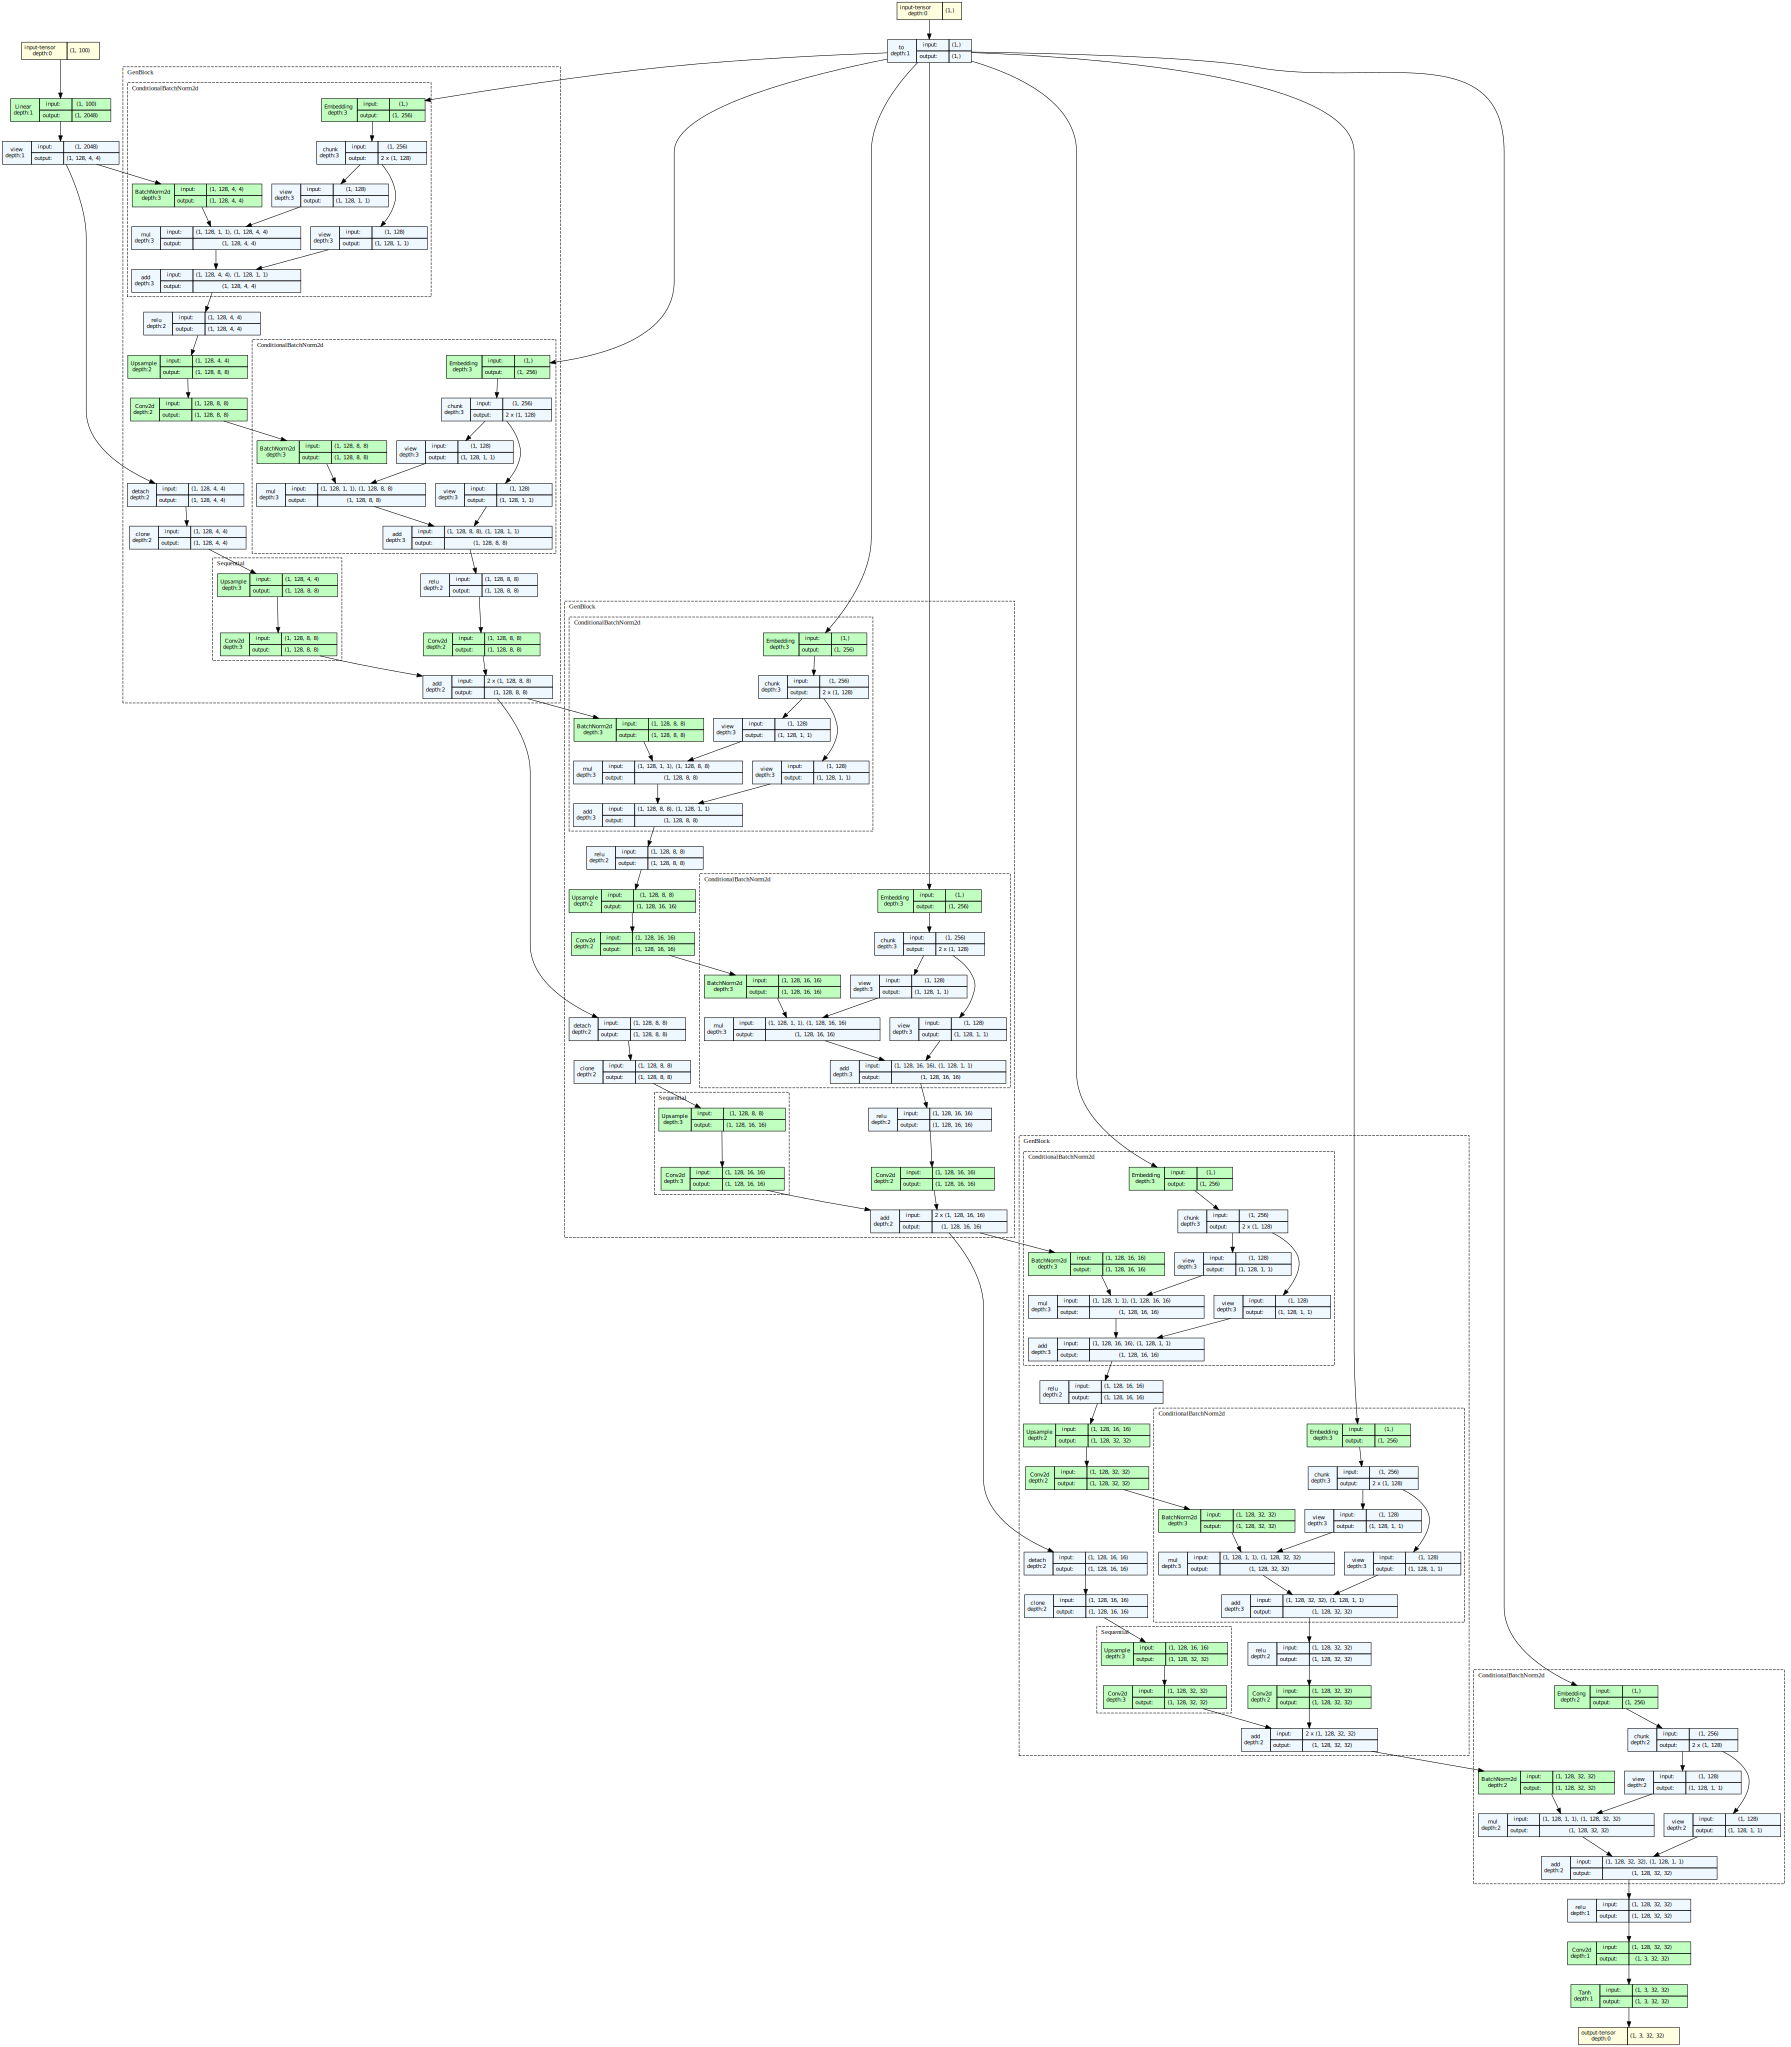

In [ ]:
model_graph = draw_graph(G , input_size= [(1,noise_dim), (1,)], expand_nested=True)
model_graph.resize_graph(scale=1)
model_graph.visual_graph
#.render(format='svg')

In [ ]:
model_graph.visual_graph.render(format='svg')

'model.gv.svg'

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            OptCriticBlock(3, 128, num=1),
            CriticBlock(128, 128, "down", num=2),
            CriticBlock(128, 128, None, num=3),
            CriticBlock(128, 128, None, num=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.linear = nn.Linear(128, 1)
        self.ac = nn.Sequential(nn.Linear(128, 10), nn.Softmax(dim=1))
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.linear.weight)

    def forward(self, x):

        x = self.model(x)
        x = torch.flatten(x, start_dim=1)
        wgan_out = self.linear(x)
        ac_out = self.ac(x)
        return wgan_out, ac_out

D = Discriminator().to(device)

In [ ]:
summary(D, (1,3,32,32), device='cuda')

torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─OptDiscBlock: 2-1                 [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 128, 16, 16]          151,168
│    │    └─Sequential: 3-2              [1, 128, 16, 16]          512
│    └─DiscBlock: 2-2                    [1, 128, 8, 8]            --
│    │    └─Sequential: 3-3              [1, 128, 8, 8]            426,240
│    │    └─Sequential: 3-4              [1, 128, 8, 8]            16,512
│    └─DiscBlock: 2-3                    [1, 128, 8, 8]            --
│    │    └─Sequential: 3-5              [1, 128, 8, 8]            327,936
│    │    └─Sequential: 3-6              [1, 128, 8, 8]            16,512
│    └─DiscBlock: 2-4                    [1, 128, 8, 8]            --
│    │    └─Sequential: 3-7              [1, 128, 8, 8]      

torch.Size([1, 3, 32, 32])


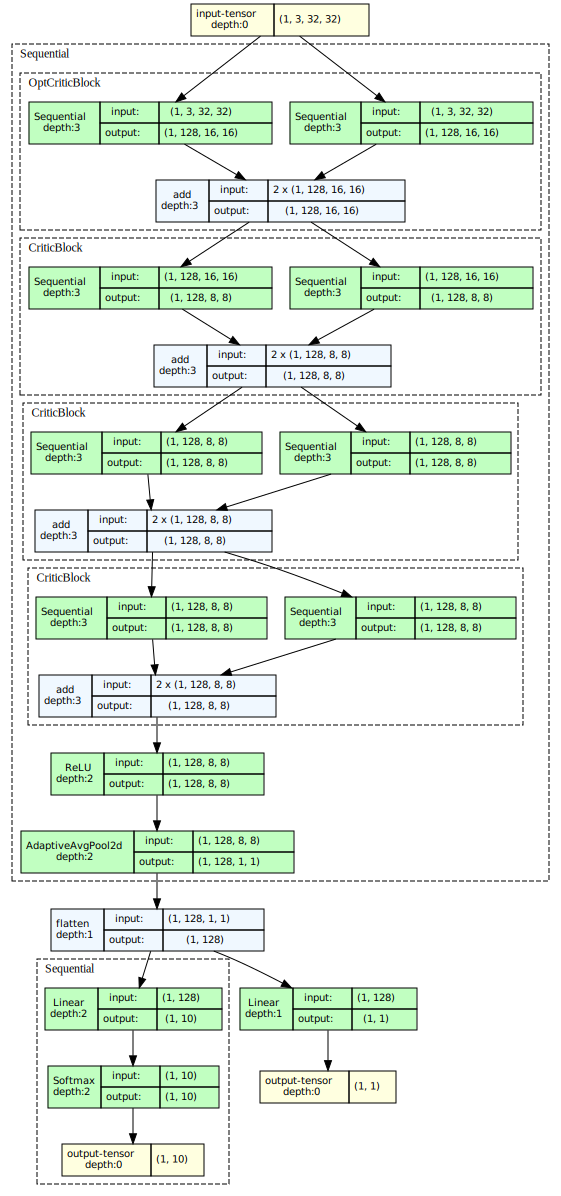

In [ ]:
model_graph = draw_graph(D , input_size=(1,3,32,32), expand_nested=True)
model_graph.resize_graph(scale=1.0)
model_graph.visual_graph
#.render(format='svg')

#Training ACWGAN

In [ ]:
def gradient_penalty(D, real, fake, labels):
    alpha = torch.rand(batch_size, 1, 1, 1).to(real.device)
    alpha = alpha.expand(real.size())

    interpolates = real + (alpha * (fake - real))
    interpolates.requires_grad_(True)
    interpolates_d, _ = D(interpolates)
    gradients = torch.autograd.grad(
        inputs=interpolates,
        outputs=interpolates_d,
        grad_outputs=torch.ones_like(interpolates_d),
        create_graph=True,
        retain_graph=True,
    )[0]

    normalised_grad = torch.norm(torch.flatten(gradients, start_dim=1), dim=1)
    gp = torch.mean((normalised_grad - 1) ** 2)
    return gp

In [ ]:
dreal_loss,dfake_loss,gen_loss ,disc_loss,gac_loss,dac_loss= list(), list(), list(),list(),list(),list()
dfake_tmp,dreal_tmp,dloss_tmp,dac_loss_tmp = list(),list(),list(),list()

In [ ]:
from numpy import mean

Generator iteration: 0/20000, g_loss: -2.9190664291381836, d_loss_fake: -0.17711229622364044, d_loss_real: 20.39699935913086


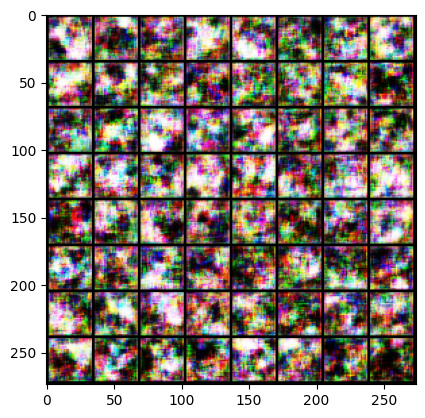

Generator iteration: 500/20000, g_loss: 14.79100513458252, d_loss_fake: -8.532463073730469, d_loss_real: -4.22286319732666


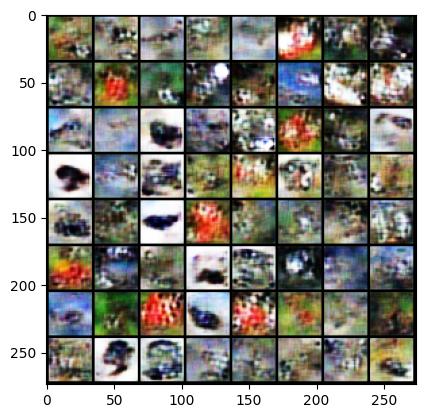

Generator iteration: 1000/20000, g_loss: 0.054683372378349304, d_loss_fake: 2.212512969970703, d_loss_real: 5.302593231201172


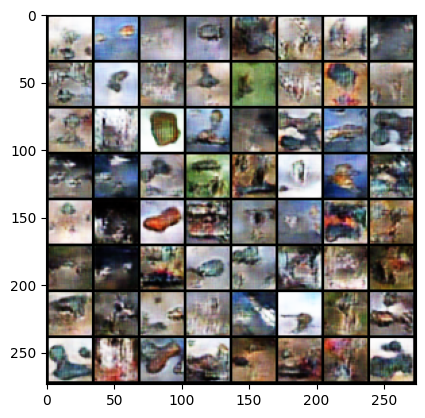

Generator iteration: 1500/20000, g_loss: -14.279817581176758, d_loss_fake: 15.267125129699707, d_loss_real: 18.74978256225586


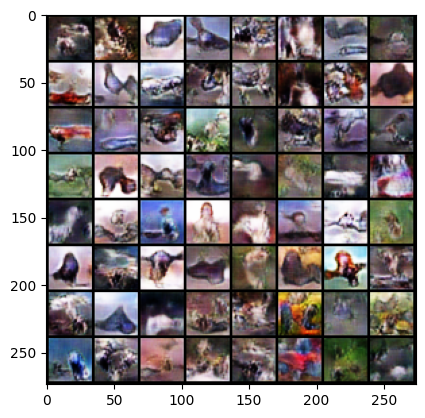

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:


learning_rate = 1e-4
b1 = 0.0
b2 = 0.999
batch_size = 64

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(b1, b2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(b1, b2))

g_sched = optim.lr_scheduler.LambdaLR(
    g_optimizer, lambda step: 1 - step / generator_iters
)
d_sched = optim.lr_scheduler.LambdaLR(
    d_optimizer, lambda step: 1 - step / generator_iters
)

data = cycle(train_loader)

AC_D_SCALE = 1
AC_G_SCALE = 0.1

for g_iter in range(generator_iters):

    for p in D.parameters():
        p.requires_grad = True

    for d_iter in range(critic_iter):
        D.zero_grad()

        images, labels = data.__next__()

        if images.size()[0] != batch_size:
            continue

        z = torch.randn(batch_size, noise_dim)

        images, labels, z = images.to(device), labels.to(device), z.to(device)

        d_loss_real, pred_real_labels = D(images)
        d_loss_real = d_loss_real.mean()
        dreal_tmp.append(d_loss_real)


        fake_images = G(z, labels)
        # print("Labels type:")
        # print(type(labels))
        # print(type(z))
        d_loss_fake, pred_fake_labels = D(fake_images)
        d_loss_fake = d_loss_fake.mean()
        dfake_tmp.append(d_loss_fake)

        gp = gradient_penalty(D, images, fake_images, labels)
        d_loss = d_loss_fake - d_loss_real + (lambda_gp * gp)


        aux_loss = F.cross_entropy(
            torch.cat((pred_real_labels, pred_fake_labels), 0),
            torch.cat((labels, labels), 0),
        )

        d_loss += AC_D_SCALE * aux_loss
        dac_loss_tmp.append(aux_loss)

        dloss_tmp.append(d_loss)
        d_loss.backward()
        d_optimizer.step()

    for p in D.parameters():
        p.requires_grad = False

    dreal_loss.append(mean(np.array([item.detach().cpu() for item in dreal_tmp])))
    dac_loss.append(mean(np.array([item.detach().cpu() for item in dac_loss_tmp])))
    dfake_loss.append(mean(np.array([item.detach().cpu() for item in dfake_tmp])))
    disc_loss.append(mean(np.array([item.detach().cpu() for item in dloss_tmp])))

    # dac_loss.append(mean(dac_loss_tmp))
    #dfake_loss.append(mean(dfake_tmp))
    #d_loss.append(mean(dloss_tmp))

    G.zero_grad()

    z = torch.randn(batch_size * 2, noise_dim).to(device)
    labels = torch.randint(0, 10, (batch_size * 2,)).to(device)
    fake_images = G(z, labels)
    g_loss, pred_gen_labels = D(fake_images)
    g_loss = -g_loss.mean()

    aux_loss = F.cross_entropy(pred_gen_labels, labels)

    g_loss += AC_G_SCALE * aux_loss
    #store losses
    gen_loss.append(g_loss)
    gac_loss.append(aux_loss)

    g_loss.backward()
    g_optimizer.step()

    g_sched.step()
    d_sched.step()

    if g_iter % 500 == 0:
        print(
            f"Generator iteration: {g_iter}/{generator_iters}, g_loss: {g_loss}, d_loss_fake: {d_loss_fake}, d_loss_real: {d_loss_real}"
        )
        with torch.no_grad():

            plt.imshow(
                torchvision.utils.make_grid(fake_images[:batch_size], normalize=True)
                .cpu()
                .data.permute(0, 2, 1)
                .contiguous()
                .permute(2, 1, 0)
            )
            plt.show()
            if not os.path.isdir(f"training_images"):
                os.makedirs(f"training_images")
            plt.savefig(f"training_images/g_iter{g_iter}.png")


with torch.no_grad():

    for i in range(10):

        z = torch.randn(batch_size, noise_dim).to(device)
        labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_images = G(z, labels)

        plt.imshow(
            torchvision.utils.make_grid(fake_images[:batch_size], normalize=True)
            .cpu()
            .data.permute(0, 2, 1)
            .contiguous()
            .permute(2, 1, 0)
        )
        plt.show()
        if not os.path.isdir(f"trained_images"):
            os.makedirs(f"trained_images")
        plt.savefig(f"trained_images/img{i}.png")

def generate_latent_points(noise_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(noise_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, noise_dim)
    return z_input

def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)


with torch.no_grad():

    for iter in range(10):
        interpolated = torch.Tensor().to(device)

        for _ in range(10):

            pts = generate_latent_points(128, 100)

            i = torch.Tensor(interpolate_points(pts[0], pts[1])).to(device)

            interpolated = torch.cat((interpolated, i))

        interpolated = interpolated.reshape(100, 128)

        l = torch.tensor([]).type(torch.IntTensor).to(device)

        for i in range(10):

            l = torch.cat(
                [l, torch.tensor(10 * [int(i)]).type(torch.IntTensor).to(device)]
            )

        imgs = G(interpolated, l)

        plt.rcParams["figure.dpi"] = 175

        plt.imshow(
            torchvision.utils.make_grid(imgs, nrow=10, normalize=True)
            .cpu()
            .data.permute(0, 2, 1)
            .contiguous()
            .permute(2, 1, 0),
            cmap=plt.cm.binary,
        )
        plt.show()
        if not os.path.isdir(f"interpolations"):
            os.makedirs(f"interpolations")
        plt.savefig(f"interpolations/{iter}.png")

In [ ]:
import torch
torch.save(G.state_dict(),img_path + 'generator_acwgan.pt')
# G.save(img_path + 'generator_acwgan.pt')
# D.save(img_path + 'discriminator_acwgan.pt')

In [ ]:
torch.save(D.state_dict(),img_path + 'discriminator_acwgan.pt')

In [ ]:
dreal_loss,dfake_loss,gen_loss ,disc_loss,gac_loss,dac_loss

In [ ]:
len(dreal_loss)

1646

In [ ]:
len(dfake_loss)

1645

# Plotting Results

In [ ]:
drloss = np.array(dreal_loss)[:1500]
dfloss = np.array(dfake_loss)[:1500]
gloss = np.array([item.detach().cpu() for item in gen_loss])[:1500]
d_loss = np.array(disc_loss)[:1500]
dacloss = np.array(dac_loss)[:1500]

In [ ]:
gacloss = np.array([item.detach().cpu() for item in gac_loss])[:1500]


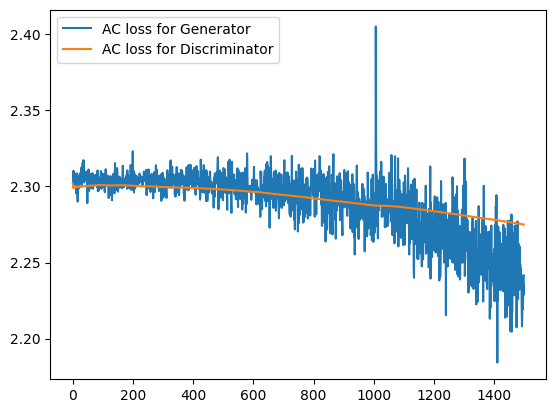

In [ ]:
import matplotlib.pyplot as plt
plt.plot(gacloss, label='AC loss for Generator')
plt.plot(dacloss, label='AC loss for Discriminator')
# plt.plot(gloss, label='gen')
plt.legend()
# plt.savefig('plot_line_plot_loss.png')
plt.show()

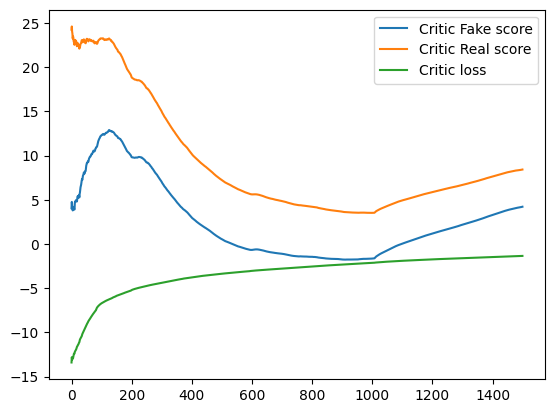

In [ ]:
plt.plot(dfloss, label='Critic Fake score')
plt.plot(drloss, label='Critic Real score')
plt.plot(d_loss, label='Critic loss')
plt.legend()
# plt.savefig('plot_line_plot_loss.png')
plt.show()

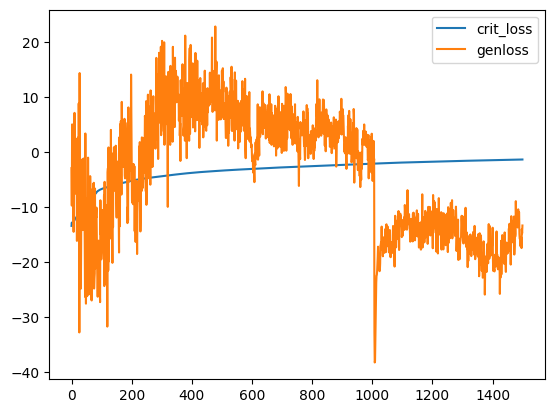

In [ ]:
plt.plot(d_loss, label='crit_loss')
plt.plot(gloss, label='genloss')
# plt.plot(gloss, label='gen')
plt.legend()
# plt.savefig('plot_line_plot_loss.png')
plt.show()

In [ ]:
import tensorflow as tf
latent_points = torch.randn(100, noise_dim).to(device)

labels = np.asarray([x for _ in range(10) for x in range(10)])
labels = torch.from_numpy(labels)
labels = labels.to(device)
# generate images
#predictioniction = G.predict([latent_points,labels])
G.eval();
# Run forward pass
with torch.no_grad():
  prediction = (G(latent_points,labels))

# Do something with pred
# prediction = prediction.detach().cpu().numpy() #

In [ ]:
pred = prediction.detach().cpu().numpy()


In [ ]:
labels

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9], device='cuda:0')

In [ ]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))

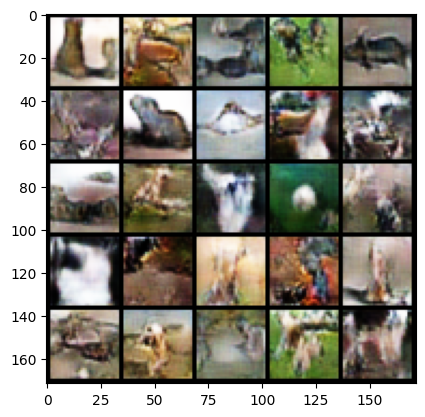

In [ ]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = torchvision.utils.make_grid(unflat_img[num_img:2*num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_new_gen_images(prediction)
#show_new_gen_images(fake_img.reshape(num_image,1,28,28))